In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
import os
sys.path.append('../src/')
from data_utils import *

/home/lee/.local/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


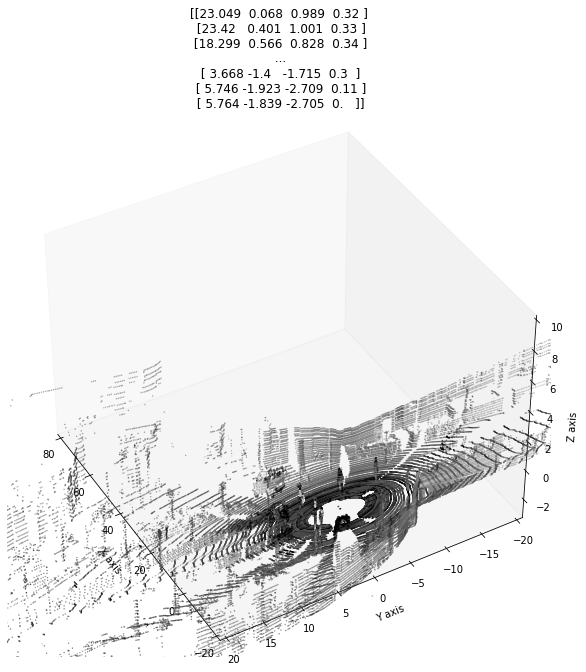

In [2]:
def draw_point_cloud(ax, title, axes=[0, 1, 2],  point_size=0.1,xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        #范围限制
        axes_limits = [
            [-20, 80], # X axis range
            [-20, 20], # Y axis range
            [-3, 10]   # Z axis range
                    ]
        axes_str = ['X', 'Y', 'Z']
        ax.grid(False)  #不要画出栅格
        
        ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)

DATA_PATH = '/home/lee/lee/ROS/data/kitti/2011_09_26/2011_09_26_drive_0005_sync'
points = read_point_cloud(os.path.join(DATA_PATH, 'velodyne_points/data/%010d.bin'%12)) #点云data的 path


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40, 150)   #观看角度
draw_point_cloud(ax, points[::5])   #每5个点画一个

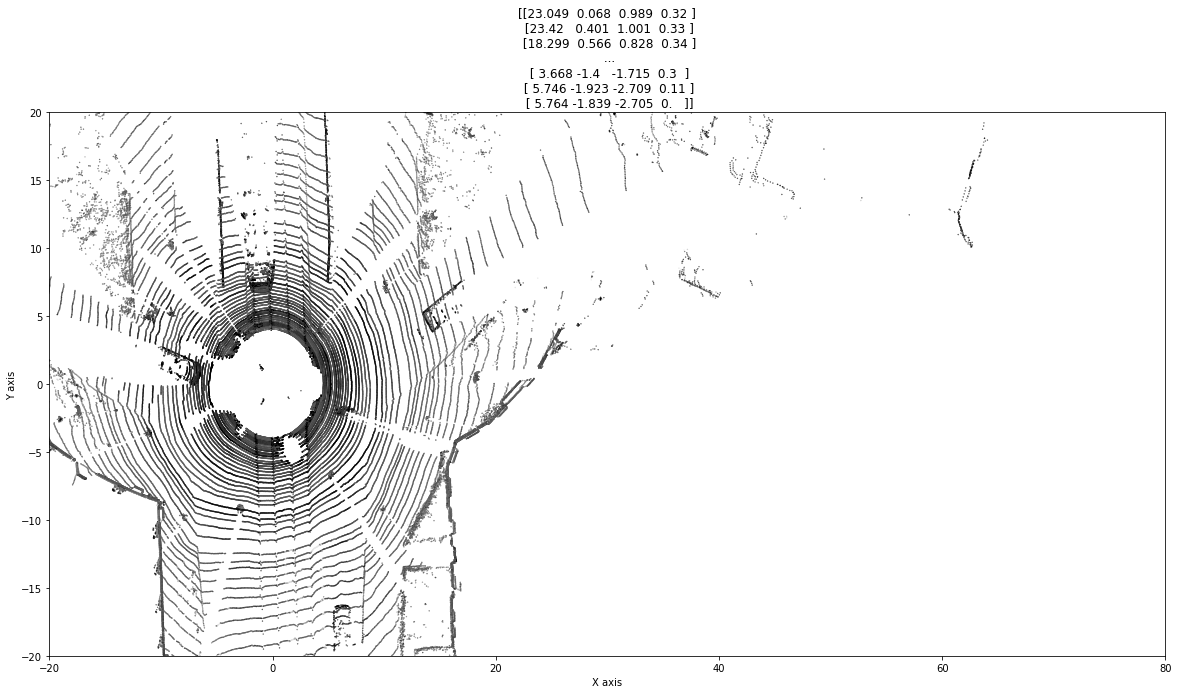

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0, 1])  #只在xoy平面上,俯视图

In [4]:
# 3D侦测框需要后边height, width, len, pos_x, y, z(相机坐标系里的坐标), rot_y(从上往下看旋转的角度)

df_tracking = read_tracking('/home/lee/lee/ROS/data/tracking/training/label_02/0000.txt')
df_tracking.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456


In [5]:
# 根据长宽高XYZ和旋转角坐标定位并画出3D框

def compute_3d_box_cam2(h, w, l, x, y, z, yaw):
    '''
    return : 3xn in cam2 coordinate
    '''
    ##旋转矩阵是绕着Y轴来的
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))
    corners_3d_cam2 += np.vstack([x, y, z]) 
    
    return corners_3d_cam2

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

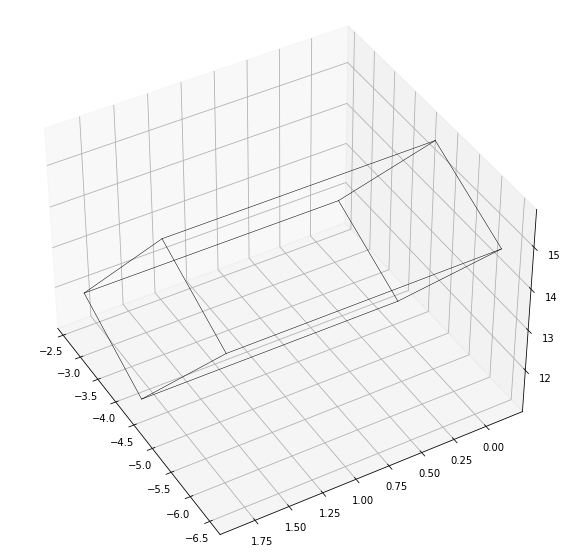

In [6]:
#先预览一个框, 得到一个3D侦测框
corners_3d_cam2 = compute_3d_box_cam2(*df_tracking.loc[2, ['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])

#3是x,y,z,8是一共长方体的8个定点定位
corners_3d_cam2.shape
#绘制
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40, 150)   #观看角度
#得到corners_3d_cam2是在照相机坐标系下得到的,所以会出现如下所示的略微奇怪的长方体
#为了可视化,应该再转为velodyne坐标系下
draw_box(ax, corners_3d_cam2)   

In [7]:
from calibration import *

calib = Calibration('/home/lee/lee/ROS/data/kitti/2011_09_26/', from_video=True)
#经过矫正到velodyne的函数,入口参数为从cam到velodyne
#需要8X3,转置一下
corners_3d_velo = calib.project_ref_to_velo(corners_3d_cam2.T).T    

corners_3d_velo
#转换完之后,每一列就是它的一个的点的坐标

array([[15.08379851, 16.04014402, 12.26572982, 11.30938431, 15.05419353,
        16.01053904, 12.23612484, 11.27977933],
       [ 6.59151436,  5.03926042,  2.7133565 ,  4.26561043,  6.59005821,
         5.03780428,  2.71190035,  4.26415429],
       [-1.70694987, -1.6939223 , -1.75149277, -1.76452034,  0.29283053,
         0.3058581 ,  0.24828763,  0.23526006]])

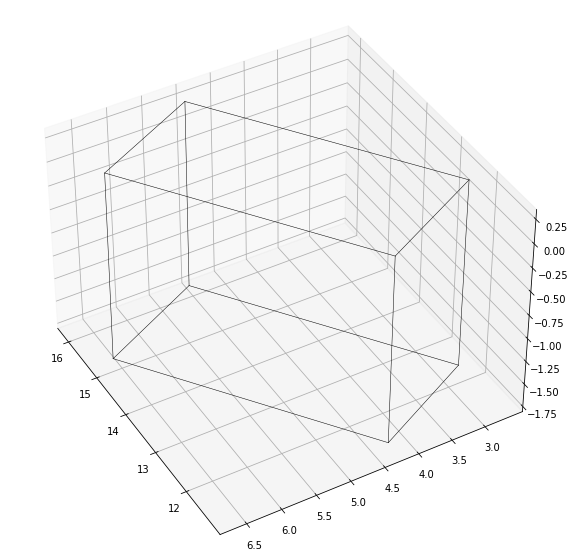

In [8]:
#绘制
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40, 150)   #观看角度
#已经转为velodyne坐标系下,可以正常显示
draw_box(ax, corners_3d_velo)   
 



/home/lee/.local/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


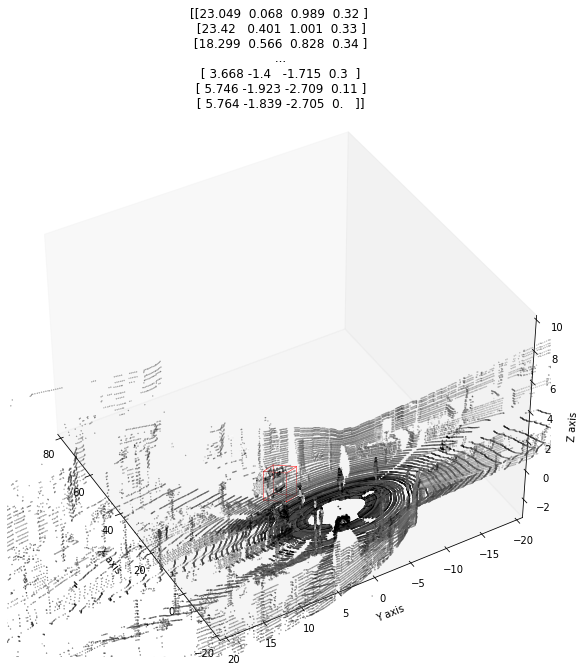

In [9]:
#绘制
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40, 150)   #观看角度
#同一坐标系下绘制出即可
draw_point_cloud(ax, points[::5])
draw_box(ax, corners_3d_velo, color='r')

/home/lee/.local/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


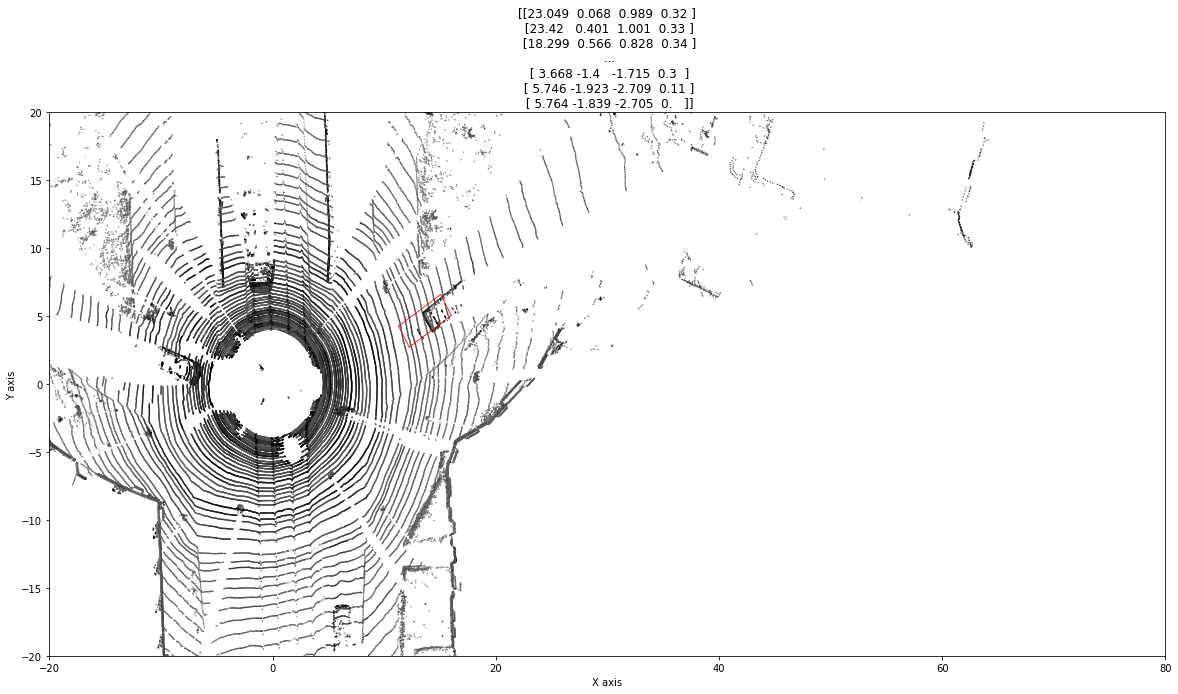

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5],axes=[0, 1])
draw_box(ax, corners_3d_velo, axes=[0, 1], color='r')

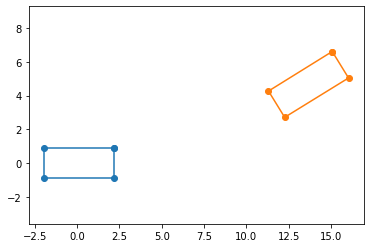

In [11]:
ego_car = np.array([[2.15, 0.9, -1.73], [2.15, -0.9, -1.73], [-1.95, -0.9, -1.73], [-1.95, 0.9, -1.73],
                   [2.15, 0.9, -0.23], [2.15, -0.9, -0.23], [-1.95, -0.9, -0.23], [-1.95, 0.9, -0.23]])


plt.axes().set_aspect('equal', 'datalim')
plt.plot(ego_car[:5, 0], ego_car[:5, 1], '-o')
plt.plot(corners_3d_velo.T[:5, 0], corners_3d_velo.T[:5, 1], '-o')


/home/lee/.local/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


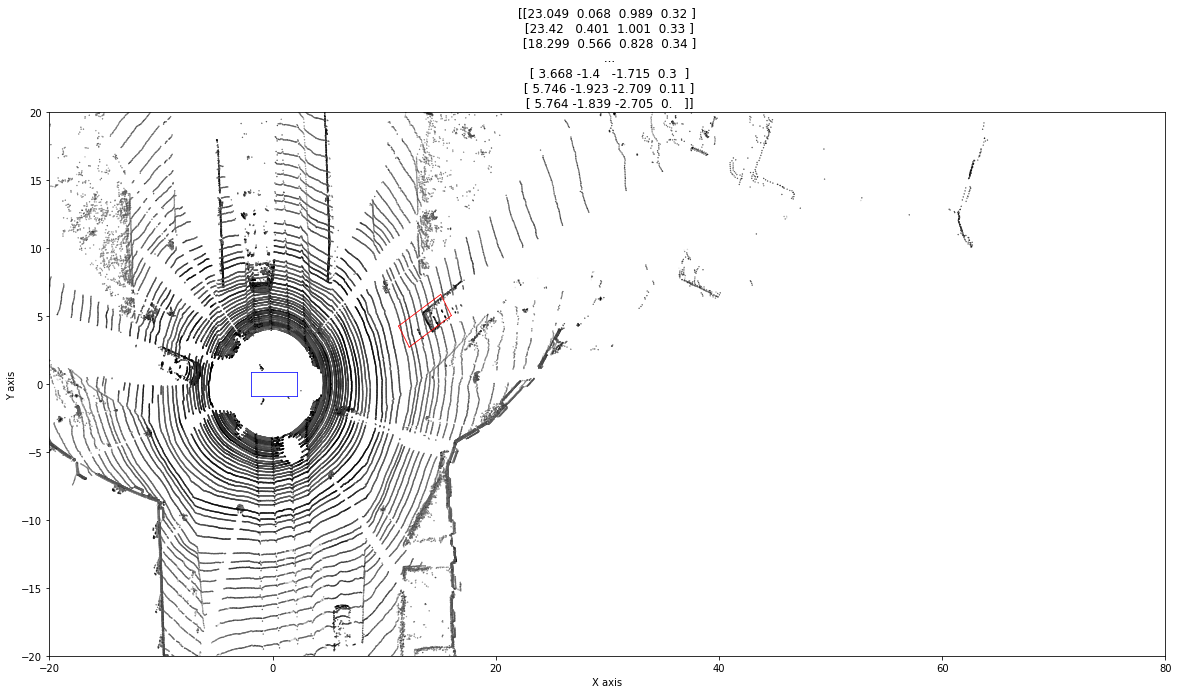

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0,1])
draw_box(ax, corners_3d_velo, axes=[0, 1], color='r')
draw_box(ax, ego_car.T, axes=[0, 1], color='b')

In [13]:
# 该函数返回类型 距离, 坐标
def distance_point_to_segment(P, A, B):
    AP = P - A
    BP = P - B
    AB = B - A
    if np.dot(AB, AP)>=0 and np.dot(-AB, BP)>=0:     #向量点积,投影在线上
        return np.abs(np.cross(AP, AB))/np.linalg.norm(AB), np.dot(AP, AB)/np.dot(AB, AB) * AB + A
    
    d_PA = np.linalg.norm(AP)
    d_PB = np.linalg.norm(BP)
    # 投影在线外
    if d_PA < d_PB:
        return d_PA, A
    return d_PB, B
        


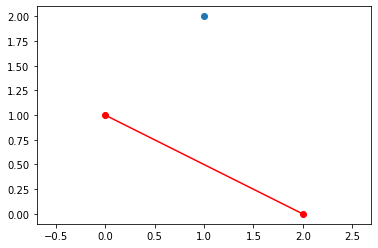

In [22]:
P = np.array([1,2],dtype=np.float64)
A = np.array([0,1],dtype=np.float64)
B = np.array([2,0],dtype=np.float64)

plt.axes().set_aspect('equal','datalim')
plt.scatter(P[0],P[1])
plt.plot(list(zip(A,B))[0],list(zip(A,B))[1],'r-o')

In [23]:
distance_point_to_segment(P,A,B)

(1.3416407864998738, array([0.4, 0.8]))

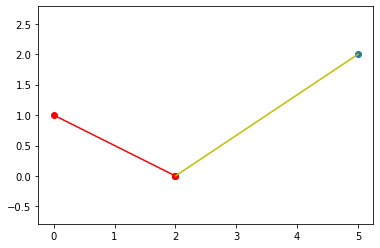

In [28]:
P = np.array([5,2],dtype=np.float64)
A = np.array([0,1],dtype=np.float64)
B = np.array([2,0],dtype=np.float64)
d,Q = distance_point_to_segment(P,A,B)

plt.axes().set_aspect('equal','datalim')
plt.scatter(P[0],P[1])
plt.plot(list(zip(A,B))[0],list(zip(A,B))[1],'r-o')
plt.scatter(Q[0],Q[1],c='k')
plt.plot(list(zip(P,Q))[0],list(zip(P,Q))[1],'y-')

In [29]:
def min_distance_cupoints(cub1, cub2):
    minD = 1e5   #先给一个非常大的值
    # 最短距离在本车的端点
    for i in range(4):    #四个顶点遍历
        for j in range(4): #另一个长方形的四条边遍历
            d, Q = distance_point_to_segment(cub1[i, :2], cub2[j, :2], cub2[j+1, :2])
            if d < minD:  #迭代最小的几个点的数值
                minD = d
                minP = cub1[i, :2]
                minQ = Q
                
    # 最短距离在其他物体的端点
    for i in range(4):    #四个顶点遍历
        for j in range(4): #另一个长方形的四条边遍历
            d, Q = distance_point_to_segment(cub2[i, :2], cub1[j, :2], cub1[j+1, :2])
            if d < minD:  #迭代最小的几个点的数值
                minD = d
                minP = cub2[i, :2]
                minQ = Q
   
    # 遍历完毕
    return minP, minQ, minD


In [31]:
ego_car[1,:2]

array([ 2.15, -0.9 ])

9.7581583575115


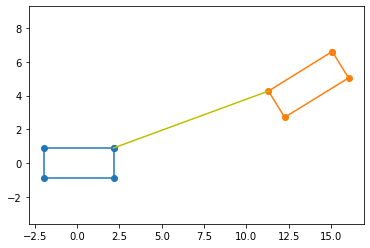

In [32]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ego_car[:5, 0], ego_car[:5, 1], '-o')
plt.plot(corners_3d_velo.T[:5, 0], corners_3d_velo.T[:5, 1], '-o')
minP, minQ, minD = min_distance_cupoints(ego_car, corners_3d_velo.T)
plt.plot((minP[0], minQ[0]), (minP[1], minQ[1]), 'y-')
print(minD)
